In [8]:
import matplotlib.pyplot as plt
import numpy as np
from SocialNetwork.social_network_environment import *
from SocialNetwork.cascade import *
from Advertising.enviroment.bid import *
from Advertising.enviroment.VCG import *
from Advertising.learners.Greedy_algorithm import *
from Advertising.learners.GTS_Learner import *
from Advertising.learners.GTS_SW_Learner import *
from Advertising.learners.TS_no_qualities import *
from tqdm.autonotebook import tqdm
from Advertising.learners.TS_sliding_window import *
import itertools
seed = 6789
random.seed(seed)
only_first = False


lambdas = [0.5, 0.42, 0.38, 0.30, 0.2, 0.05]
social_network = social_network_environment()
social_network.init_from_json(
    json_path_network='Config/network.json', json_path_features='Config/features.json')

adversary_bids = []
for _ in range(0, 10):
    adversary_i_bids = []
    for __ in range(0, 5):
        adversary_i_bids.append(random.randint(0, 4))
    adversary_bids.append(adversary_i_bids)


with open("Config/estimated_influence.json", "r"):
    data = json.load(open("Config/estimated_influence.json"))

active_by_influence_reward = np.array(data.get("estimated_influence"))


In [9]:
expected_values = []
expected_values2 = []
sw_size = 5000
arms = arms_creation(seed=30291, number_of_arms=20)
ts_learner = GTS_SW_Learner(20, arms, variance=20, size_SW=sw_size, ad_id=1)
ts_learner2 = GTS_SW_Learner(20, arms, variance=10, size_SW=sw_size, ad_id=1)
n_experiments=15000

for j in range(0, 1):
    best_Arm = []
    print("This is TS number " + str(j))

    best_arm, best_arm_index, number_of_pulls, expected_values, thing_to_plot, clairvoyants, clair_ex = test_sw(
        ts_learner, arms, adversary_bids.copy(), only_first, n_experiments, lambdas, social_network, sw_size)
    best_arm2, best_arm_index2, number_of_pulls2, expected_values2, thing_to_plot2, clairvoyants2, clair_ex2 = test_sw(
        ts_learner2, arms, adversary_bids.copy(), not only_first, n_experiments, lambdas, social_network, sw_size)


This is TS number 0
Valori non solo prima posizione:
[1 1 2 0 4]
[0.000e+00 0.000e+00 5.000e+00 1.600e+01 4.807e+03 1.000e+00 3.000e+00
 1.160e+02 0.000e+00 0.000e+00 8.000e+00 2.000e+00 4.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 3.600e+01 0.000e+00 0.000e+00]
[ 0.          0.          0.19789474 -2.27105263  1.14519451 -7.24
 -2.54333333 -0.04401089  0.          0.         -1.49       -2.07631579
 -1.37        0.         -0.55        0.          0.          0.89222222
  0.          0.        ]
Valori solo prima posizione:
[3 1 2 2 3]
[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00
 1.000e+00 0.000e+00 0.000e+00 4.997e+03 1.000e+00 0.000e+00]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         2.74303582
 3.11       0.        ]


THE BEST ARM FOR EXPERIMENT TOTAL IS: [1 1 2 0 4] INDEX 4
THE BEST ARM FOR EXPERIMENT ONLY FIRST IS: [3 1 2 2 3] INDEX 18


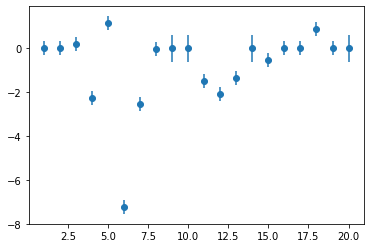

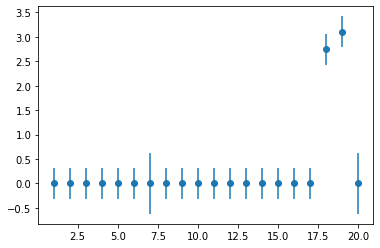

[[1 1 2 0 4]
 [2 3 2 1 1]
 [1 1 2 0 4]]
[1.739154967313251, 6.170927318295735, 1.1451945080091548]
[[3 3 4 2 3]
 [0 0 1 4 0]
 [3 1 2 2 3]]
[1.9040192743763915, 1.2022040724994563, 3.110000000000002]


In [10]:
print("THE BEST ARM FOR EXPERIMENT TOTAL IS:",
      arms[best_arm_index], "INDEX", best_arm_index)
print("THE BEST ARM FOR EXPERIMENT ONLY FIRST IS:",
      arms[best_arm_index2], "INDEX", best_arm_index2)

array = [i+1 for i in range(0, 20)]


plt.figure(1)
plt.errorbar(array, expected_values, yerr=(1/ts_learner.tau0), fmt='o')
plt.figure(0)
plt.errorbar(array, expected_values2, yerr=(1/ts_learner2.tau0), fmt='o')

plt.show()
print(np.array(arms)[clairvoyants])
print(clair_ex)
print(np.array(arms)[clairvoyants2])
print(clair_ex2)


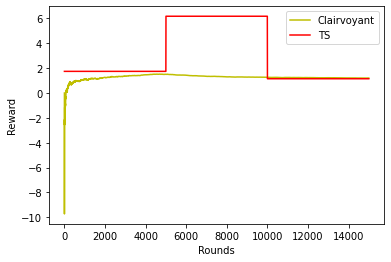

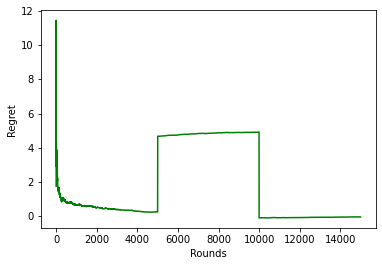

In [11]:
best_values = []
j = 0
k = 0
for i in range(n_experiments):
    k += 1
    best_values.append(clair_ex[j])
    if k == sw_size:
        k = 0
        j += 1

regret_no_qualities = [
    best_values[x] - thing_to_plot[x] for x in range(len(thing_to_plot))]
plt.figure(0)
plt.plot(thing_to_plot, 'y')
plt.ylabel("Reward")
plt.xlabel("Rounds")
plt.plot(best_values, 'r')
plt.legend(["Clairvoyant", "TS"])

plt.figure(1)
plt.ylabel("Regret")
plt.xlabel("Rounds")
plt.plot(regret_no_qualities, 'g')


Here are reward and regret for the case without ad qualities, with only ads in first position


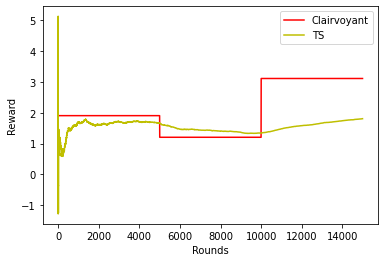

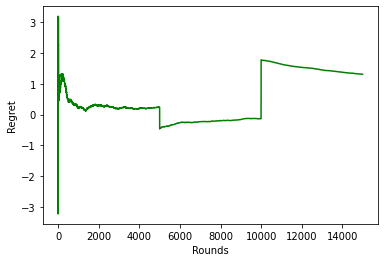

In [12]:
print("Here are reward and regret for the case without ad qualities, with only ads in first position")
best_values2 = []
j = 0
k = 0
for i in range(n_experiments):
    k += 1
    best_values2.append(clair_ex2[j])
    if k == sw_size:
        k = 0
        j += 1

regret_no_qualities2 = [
    best_values2[x] - thing_to_plot2[x] for x in range(len(thing_to_plot2))]
plt.figure(0)
plt.plot(best_values2, 'r')
plt.plot(thing_to_plot2, 'y')
plt.ylabel("Reward")
plt.xlabel("Rounds")
plt.legend(["Clairvoyant", "TS"])

plt.figure(1)
plt.ylabel("Regret")
plt.xlabel("Rounds")
plt.plot(regret_no_qualities2, 'g')
